In [31]:
from pathlib import Path
import json
from pprint import pprint
import copy
from core.forecasts.buildingEnergyForecast import BuildingEnergyForecast
from core.optimizer.mpc import MPC
from core.simulation.modelica import ModelicaAgent
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
schema_path = Path.cwd() / 'core' / 'data_models' /\
        'schema' / 'BuildingEnergyForecast.json'
with open(schema_path) as f:
    data_model = json.load(f)

building_forecasts = {}
for building_ix in range(5):
    
    entity_id = f'BuildingEnergyForecast:DEQ:MVP:{"{:03}".format(building_ix)}'
    building_energy_forecast = BuildingEnergyForecast(
        entity_id=entity_id,
        entity_type="BuildingEnergyForecast",
        building_ix=building_ix,
        offline_modus=True,
        data_model=copy.deepcopy(data_model)  # necessary because id gets popped from data_model. TODO change that in json schema to fiware converter
    )
    building_forecasts[building_ix] = building_energy_forecast
    
schema_path = Path.cwd() / 'core' / 'data_models' /\
    'schema' / 'MPC.json'
with open(schema_path) as f:
    data_model = json.load(f)
mpc = MPC(
    entity_id='MPC:DEQ:MVP:000',
    entity_type='MPC',
    data_model=data_model,
    offline_modus=True  
)

schema_path = Path.cwd() / 'core' / 'data_models' /\
    'schema' / 'ModelicaAgent.json'
with open(schema_path) as f:
    data_model = json.load(f)
modelica = ModelicaAgent(
    entity_id='ModelicaAgent:DEQ:MVP:000',
    entity_type='ModelicaAgent',
    data_model=data_model,
    offline_modus=True      
)

29.02.2024-18:08:07 INFO BuildingEnergyForecast:DEQ:MVP:000: Heat Predictor learned
29.02.2024-18:08:08 INFO BuildingEnergyForecast:DEQ:MVP:001: Heat Predictor learned
29.02.2024-18:08:09 INFO BuildingEnergyForecast:DEQ:MVP:002: Heat Predictor learned
29.02.2024-18:08:10 INFO BuildingEnergyForecast:DEQ:MVP:003: Heat Predictor learned
29.02.2024-18:08:13 INFO BuildingEnergyForecast:DEQ:MVP:004: Heat Predictor learned


[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_3.heatPump.con: The constant homotopyInitialization has been modified from its default value. This constant will be removed in future releases.
  Failed condition: false

[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_3.heatPump.eva: The constant homotopyInitialization has been modified from its default value. This constant will be removed in future releases.
  Failed condition: false

[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_1.heatPump.con: The constant homotopyInitialization has been modified from its default value. This constant will be removed in future releases.
  Failed condition: false

[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_1.heatPump.eva: The constant homotopyInitialization has been modified from its default value. This constant will be removed in futu

In [33]:
STEPS = 300
modelica_results = None
soc_init = None

results = []
for _ in tqdm(range(STEPS)):
    
    input_dict_mpc = {}
    building_pred = {}
    for ix, forecast in building_forecasts.items():
        if modelica_results is None:
            prev_input = None
        else:
            prev_input = {}
            thermal_name = f'thermalDemand{ix}_prev'
            prev_input[thermal_name] = modelica_results[thermal_name]
            prev_input['sinTime'] = modelica_results['sinTime']
        
        ff = forecast.predict(prev_input=prev_input)
        
        
    
        for attr, values in ff.items():
            translation = mpc.attr_translation[attr]
            if translation not in input_dict_mpc:
                input_dict_mpc[translation] = {}
            
            input_dict_mpc[translation][ix] = values

    mpc_results = mpc.predict(input_dict=input_dict_mpc,
                              soc_init=soc_init)
    
    input_modelica_keys = ['relativePower1',
                       'relativePower2',
                       'relativePower3']
    if mpc_results is not None:
        input_modelica = {key: mpc_results[key] for key in input_modelica_keys}

    modelica_results = modelica.do_step(input_modelica)
    results.append(modelica_results)
    soc_init = {'soc': {
        0: {'tes': 0},
        1: {'tes': modelica_results['SOC1']},
        2: {'tes': modelica_results['SOC2']},
        3: {'tes': modelica_results['SOC3']},
        4: {'tes': 0},
    }}
        

  0%|          | 0/300 [00:00<?, ?it/s]29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:000: NaNs in array. Filling with 0
29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:001: NaNs in array. Filling with 0
29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:002: NaNs in array. Filling with 0
29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:003: NaNs in array. Filling with 0
29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:004: NaNs in array. Filling with 0
  0%|          | 1/300 [00:00<01:25,  3.52it/s]29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:000: NaNs in array. Filling with 0
29.02.2024-18:08:18 WARNING BuildingEnergyForecast:DEQ:MVP:001: NaNs in array. Filling with 0
100%|██████████| 300/300 [01:11<00:00,  4.21it/s]


In [34]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(results)
df

,SOC1,SOC2,SOC3,thermalDemand0,thermalDemand0_prev,thermalDemand1,thermalDemand1_prev,thermalDemand2,thermalDemand2_prev,thermalDemand3,thermalDemand3_prev,thermalDemand4,thermalDemand4_prev,sinTime
0,759016.411598,759014.425773,759008.548079,1512.50,"[3363.44, 3314.99, 3150.17]",1618.26,"[3628.03, 3374.08, 3357.27]",1637.69,"[1969.85, 1957.87, 1827.09]",1685.15,"[2096.31, 1771.91, 1700.12]",5734.53,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
1,758777.019015,758794.089575,758781.352250,1805.91,"[3363.44, 3314.99, 3150.17]",1935.05,"[3628.03, 3374.08, 3357.27]",1785.34,"[1969.85, 1957.87, 1827.09]",1839.71,"[2096.31, 1771.91, 1700.12]",6160.41,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
2,758497.797940,758553.390441,758533.008220,2083.02,"[3363.44, 3314.99, 3150.17]",2234.25,"[3628.03, 3374.08, 3357.27]",1925.70,"[1969.85, 1957.87, 1827.09]",1986.88,"[2096.31, 1771.91, 1700.12]",6538.19,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
3,758183.209613,758298.288420,758267.166328,2345.05,"[3363.44, 3314.99, 3150.17]",2517.18,"[3628.03, 3374.08, 3357.27]",2041.23,"[1969.85, 1957.87, 1827.09]",2127.18,"[2096.31, 1771.91, 1700.12]",6893.89,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
4,757840.413950,758030.441740,757987.988881,2567.81,"[3363.44, 3314.99, 3150.17]",2743.18,"[3628.03, 3374.08, 3357.27]",2143.51,"[1969.85, 1957.87, 1827.09]",2234.13,"[2096.31, 1771.91, 1700.12]",7194.07,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,616479.577436,671216.861105,669368.014916,3249.29,"[3363.44, 3314.99, 3150.17]",3476.44,"[3628.03, 3374.08, 3357.27]",2081.73,"[1969.85, 1957.87, 1827.09]",2085.98,"[2096.31, 1771.91, 1700.12]",5471.52,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
296,616023.814421,670965.406232,669089.694382,3382.70,"[3363.44, 3314.99, 3150.17]",3646.93,"[3628.03, 3374.08, 3357.27]",2011.86,"[1969.85, 1957.87, 1827.09]",2227.78,"[2096.31, 1771.91, 1700.12]",5913.72,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
297,615570.279854,670719.214171,668827.524117,3363.44,"[3363.44, 3314.99, 3150.17]",3628.03,"[3628.03, 3374.08, 3357.27]",1969.85,"[1969.85, 1957.87, 1827.09]",2096.31,"[2096.31, 1771.91, 1700.12]",5537.62,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"
298,615148.462085,670474.525694,668605.940088,3314.99,"[3363.44, 3314.99, 3150.17]",3374.08,"[3628.03, 3374.08, 3357.27]",1957.87,"[1969.85, 1957.87, 1827.09]",1771.91,"[2096.31, 1771.91, 1700.12]",5676.72,"[5537.62, 5676.72, 5605.12]","[9, 10, 11]"


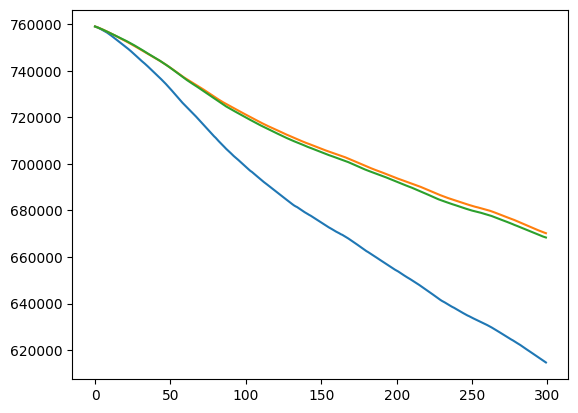

In [35]:
plt.plot(df.SOC1)
plt.plot(df.SOC2)
plt.plot(df.SOC3)